# Project number 7: Classification of normal vs tumor samples

The aim of this notebook is to download the TCGA GRCh38 Breast Cancer gene expression data from the GenoSurf interface and analyse them using different machine learning techniques in order to classify normal and tumor samples.
With this purpose different classification techniques of machine learning have been used such as Logistic Regression, Support Vector Machines, Random Forest and K-Nearest Neighbors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests 
import time
import threading 
import concurrent.futures
import os
import math
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy import stats

# Data download

The data are downloaded from the GenoSurf website and include 1108 tumor samples and 113 control samples. Each of those files contain many different information, the only one of interest for this analysis is the fpkm and the correspondant ensembl gene id. All the data then are condensed in a single matrix.

First we read the txt files which contains all the links for the samples.
Then to download every single link using the requests library, we can do one at the time. Doing like this will take a bit of time since we have to wait for the response of the site for every url. A better option is to use concurrent programming, in this way we will move on the next url while the previous is waiting for a response, so that we can make multiple requests at the same time.
It is not necessary to use parallel programming because we are not processing the data so it is not a CPU bound operation but is a IO bound operation.

We can loop over our list of url, both the control one and the tumoral one, and using requests to download it. We can use the map method to which we can pass a function (download_url_control/tumoral) and a list of parameters (url_control/tumoral) and have that function run with every value in the list

In [2]:
control_data = pd.read_table("Control.txt", header = None)          #Download the file containing all the urls for control samples
tumoral_data = pd.read_table("Experimental.txt", header = None)     #Download the file containing all the urls for tumoral samples

In [15]:
url_control = []
names_control_files = []
for x in range(0,len(control_data),2):    #We loop with an interval of 2 because for every file we have a region file and
    new = control_data.iloc[x,0]          #a metadata file which is not of interest.
    url_control.append(new)               #Add the url to the list

In [4]:
url_tumoral = []                          #We do the same for the tumoral samples
names_tumoral_files = []
for x in range(0,len(tumoral_data),2):
    new = tumoral_data.iloc[x,0]
    url_tumoral.append(new) 

In [10]:
def download_url_control(single_url):      #Function used to download data
    file_bytes = requests.get(single_url).content
    file_name = single_url.split('/')[6]        #We get the file name for every file
    with open(file_name, 'wb') as file:         #Using the with open statement we don't have to close the file
        file.write(file_bytes)
        print(f'{file_name} was downloaded')      #We print file name to be sure that the program is working properly
        names_control_files.append(file_name)     #Finally we add the file name to a list

In [6]:
def download_url_tumoral(single_url):       #Same function for tumoral samples
    file_bytes = requests.get(single_url).content
    file_name = single_url.split('/')[6]
    with open(file_name, 'wb') as file:
        file.write(file_bytes)
        print(f'{file_name} was downloaded')
        names_tumoral_files.append(file_name)  

In [16]:
start_time = time.time()                         #Measure the time needed
with concurrent.futures.ThreadPoolExecutor() as executor:        #We are using a thread for every element
     executor.map(download_url_control, url_control)             #With map we can run the download_url function with every element of the list url
print("--- %s seconds ---" % (time.time() - start_time))         #Print the time required for downloading all the files

0f263a65-a664-4e23-bd9c-91e955f3bf21-geq was downloaded
0b937a20-66d4-4d05-bf50-4828cead9c92-geq was downloaded
01163f75-8956-40a6-97a5-3c0478d904f8-geq was downloaded
10d54893-647f-40a9-8aa7-602e04d55faf-geq was downloaded
08236177-a046-4cfe-a11c-a24292a1f777-geq was downloaded09f570eb-a751-41db-9511-300be228f24e-geq was downloaded

000d877f-8d03-44bc-8607-27b5ba84b5fe-geq was downloaded
02222fea-f3da-4328-8188-8ef24d1f55e4-geq was downloaded
120bc298-f016-4c80-aa5f-a9006444942c-geq was downloaded
1b831e2d-c265-4eac-aee0-248493a14218-geq was downloaded
2147e537-16f0-4bc3-a87f-572f8dcb9191-geq was downloaded
1457ae2c-4b9b-448a-b455-432a7121beb4-geq was downloaded
27d4c881-e906-437f-921d-467eb107798a-geq was downloaded
1e55cf08-da43-471d-813c-9d37c7abc730-geq was downloaded
2b11e565-01a8-4054-a200-03e06765bd5e-geq was downloaded
288c81eb-4c43-406b-a5e5-fee452a95afb-geq was downloaded
3078c384-b624-4f5a-ae36-fc896212e616-geq was downloaded
2d5351f1-e9d7-44a3-ae43-f595a0151516-geq was dow

In [13]:
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
     executor.map(download_url_tumoral, url_tumoral)
print("--- %s seconds ---" % (time.time() - start_time))

001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq was downloaded
00ee8acd-0841-4c85-a99a-8966a6828dd7-geq was downloaded
006e88ce-ad31-45bf-8da5-802f0e387b3a-geq was downloaded
00168e86-d23a-48ae-8c60-36d970051907-geq was downloaded
00e597fa-72b4-4e92-9428-7ec686e4cc0b-geq was downloaded
00683b30-d386-48a8-ad29-4f4698864c66-geq was downloaded
00a3c8f4-bd75-4aa8-abb7-21005b1a5ad8-geq was downloaded
01370d42-f75c-4532-9b9c-24ff7302b033-geq was downloaded
0172d30c-287c-4f3e-b70c-5760c6dccb7c-geq was downloaded
02873204-1097-45ea-b143-a97f3e047537-geq was downloaded
02a7b2f2-7ae3-426c-9ec5-cdb5ffcaaaa6-geq was downloaded
02a65cb0-158c-478b-b72e-d6bae04429c7-geq was downloaded
02cf1db9-55c0-4ece-b230-966b30cd0b94-geq was downloaded
02d9d59b-de6f-41c7-b529-142116debfd9-geq was downloaded
0042b857-502f-4d8e-baac-845c1a9bb64b-geq was downloaded
0307bd0b-b59a-4996-b89d-612e72652890-geq was downloaded
032db552-7828-4ed4-a1d7-b01b7fa89e29-geq was downloaded
041c71a0-06d5-44a5-8930-7f1dd2a638d1-geq was dow

21f22460-fac7-4dbc-8ab2-75738331cb5c-geq was downloaded
222a566c-2bad-4b47-97dc-ca1f60a9a981-geq was downloaded
222c7e4d-f6ed-4db0-ba36-1670159cee1b-geq was downloaded
224cbe13-ebf8-41eb-ab1c-1d6792a66774-geq was downloaded
2448118f-9664-4b9e-b67f-c019cf5b8d35-geq was downloaded
22fe5cac-0623-4d0a-a158-f15fb5477d8f-geq was downloaded
2407816a-86e7-4094-a028-e81c0cda5448-geq was downloaded
22e03b77-aa0f-4348-98c1-9b0914e8af8b-geq was downloaded
229ebbe9-4dc8-434f-998c-fc0660cd2b00-geq was downloaded
2281c64c-9394-44f6-a4e7-87c7cce08c13-geq was downloaded
2424c058-78c6-41dd-86e9-efcd61b72add-geq was downloaded
24664b94-f5b5-4a99-a09b-66e23edf5916-geq was downloaded
24c0ef45-670d-4595-b623-87f81aeb92a7-geq was downloaded
24ef9702-a1e5-4276-abb2-87088861d471-geq was downloaded
25068ef3-d87f-45e2-a15f-152b87e9dedb-geq was downloaded
24e6e8f5-3caa-46f0-8915-7bd09f0736f9-geq was downloaded
254c611f-7808-4745-9155-f2d578b29df2-geq was downloaded
253e692f-71db-4a5a-b2f4-9e640ef831a2-geq was dow

429b50eb-316f-459c-bc3a-0aca6e6dba46-geq was downloaded
40c7e862-e1f6-4425-af9d-c9d07161a2ed-geq was downloaded
428ca7a1-6f08-4426-8f2d-28939166df70-geq was downloaded
422a4277-12f1-42ae-9f94-88d37517b9b0-geq was downloaded
41ab76d7-fae0-490c-9545-be576b64b827-geq was downloaded
42a7e579-365d-4393-8b98-e4516863299e-geq was downloaded
42b99ee7-a1ae-4383-b343-adf468cb8b51-geq was downloaded
4328ae51-6063-4296-b266-a70bc5dda94f-geq was downloaded
43326f71-c61c-410b-af4b-c71a054e27c9-geq was downloaded
42ba8e87-8d37-4cbd-82f0-bca0cbe5dcd3-geq was downloaded43a88718-f528-4d0b-88e6-f2ade6854c53-geq was downloaded

42c88ed3-de96-487d-8b03-e1d4269d0505-geq was downloaded
43bbd0f7-87d7-472f-ad3e-e016df3d5d89-geq was downloaded
42e2160c-07b5-4be6-a989-1e3474926d2a-geq was downloaded
433b49ba-949b-4914-985a-be19b3b32502-geq was downloaded
451099b0-f348-4aec-bf9f-2982601f013c-geq was downloaded
44bd10a8-c4c0-466c-8cd8-31a5da70ba0b-geq was downloaded
43c8eaea-f686-4e28-ba9c-360fea61b3ca-geq was dow

5db1c37a-2329-4bd3-baf2-89d26a8959fa-geq was downloaded
5e032694-2d7f-4e11-8800-0451ff71e5fe-geq was downloaded
5e04619f-0fa5-45fa-a30b-31b062600047-geq was downloaded
5efabaa8-f296-4c9c-9632-559ef7f6dd44-geq was downloaded
5f5a884c-ffbd-401a-8689-baded1bdbe50-geq was downloaded
5e9f382b-467c-450b-9921-828e39759a44-geq was downloaded
5e32f7e7-6022-4ce2-aa79-4c6671493406-geq was downloaded
61017170-a36a-4ce9-9b8e-324755b88dd7-geq was downloaded
5f714b76-1ed1-4828-8b66-3627c5d78189-geq was downloaded
60534f8f-970a-4308-9844-a3a41dd6c187-geq was downloaded
60f078d7-d594-48a2-9011-f0f926243a42-geq was downloaded
6050d8b9-2d10-4a03-ae57-979cba25bb70-geq was downloaded
6022db68-1e06-4974-b657-cd65aed560c4-geq was downloaded
6130b450-8b88-4a9a-b462-a34ec94183c9-geq was downloaded
600db536-d7c5-4cfa-bb80-fcc269b96b8c-geq was downloaded
616255fe-88b3-4567-ae8d-bd68dd8380a3-geq was downloaded
61c279ee-777a-4c05-bc38-e1a9183faaff-geq was downloaded
6223244a-ed38-46b5-8e65-cc8e4926c809-geq was dow

7c355987-c70f-43f1-94cc-f4d12afe0132-geq was downloaded
7bbe4637-394e-42c0-af7d-6184c3f48916-geq was downloaded
7c73dae6-4478-4cbc-aee1-0b18e730f7a2-geq was downloaded
7bc7f99c-28d4-4b54-b9bd-53d5de00cab7-geq was downloaded
7d6b6a17-5f1e-4586-9316-195c0e96925c-geq was downloaded
7e84df9f-1da5-4add-a5e8-a9d9d8af409c-geq was downloaded
7d34b1bc-ac5a-4365-8dae-75b3f2ea5055-geq was downloaded
7e2a8676-10a4-4abf-b153-2255e06bcb40-geq was downloaded
7dbd8795-b264-4f68-bdea-4cfe39884864-geq was downloaded
7e073ecd-452a-4cba-9dfd-8601f3245721-geq was downloaded
7e09faf6-137d-4d33-98dd-80c48af7ebab-geq was downloaded
7ddad1e7-783e-4095-87e0-48dbf5c5aa39-geq was downloaded
7edc6614-6c8b-43ec-87dd-7720961bd174-geq was downloaded
7f57b9e7-1b1b-4e07-beb4-b877b7651f7b-geq was downloaded
803bb42f-e0f2-44b6-aebb-8f956646ecc7-geq was downloaded
80562b20-3e3e-4f77-8ca2-958f8636d720-geq was downloaded
7fdf1ebf-149a-43d5-bae7-6e01beb647dd-geq was downloaded
7f8c9d62-0803-44d6-9375-b4e71612a0b1-geq was dow

9f693816-6957-413c-a100-54f7bc0eddf9-geq was downloaded
a09baab9-3eac-4271-9c12-2684642f8869-geq was downloaded
9fc55d1c-ecb6-4406-bf25-34f59a0dcfec-geq was downloaded
a14dc21a-6a46-4be8-9247-76cbc70dfe8b-geq was downloaded
a04ad65d-6d83-4e84-8bd8-3cab2a195642-geq was downloaded
a0059fcb-6adc-47f4-8601-b7eed9e12576-geq was downloaded
a18a4d65-5383-4c29-ac03-959f8b9cb37d-geq was downloaded
a1460e9a-c4aa-4e07-abf4-fdb5f42f5eeb-geq was downloaded
a083b072-7c1e-4ed6-90cf-1e49d21df4cb-geq was downloaded
a2c80f8e-f08d-4574-90a0-f0651c0a9b1b-geq was downloaded
a27c5907-1ad2-4414-a9c9-448f1b484946-geq was downloaded
a2cf164c-5b26-43eb-9de9-d1d457a5de06-geq was downloaded
a2405d64-34eb-4915-abf7-8530151d5cb0-geq was downloaded
a2bec98a-d946-40d2-b4d9-6495d815de9a-geq was downloaded
a2f3fd7f-9a5d-44aa-8810-4978abad6e12-geq was downloaded
a26b4751-91a2-420c-9ff3-7df7361939fd-geq was downloaded
a3568fd6-4b6d-4507-9c59-1788834d3a75-geq was downloaded
a5f14d53-fe35-494e-b6b1-bc5c8484e4a9-geq was dow

c50e1f9f-6059-4609-876d-938efb8a784e-geq was downloaded
c71ca9f7-248f-460c-b5d3-afb2c648fef2-geq was downloaded
c5a7673a-c45e-4789-a2c8-32889f39c102-geq was downloaded
c643222a-e138-4b3c-a96d-02be24ccb0d0-geq was downloaded
c791026a-9fda-47b4-86fd-9b5933325326-geq was downloaded
c7d2b685-5f11-4879-82d5-e983b5dbb07d-geq was downloaded
c6929312-e22d-4d4e-830d-6f735184d9b2-geq was downloaded
c7e03f4d-910e-4913-aac6-de1b70a47479-geq was downloaded
c7139402-146f-4c49-bcd0-f2a6a378911e-geq was downloaded
c870e04b-c3b7-495c-8465-7ef2a00fadc7-geq was downloaded
c943873c-e153-42bc-a8de-e1080b252e81-geq was downloaded
c7f57147-b774-4209-8b7f-2666f59543d8-geq was downloaded
ca39657a-073d-4b89-a3da-900f7c9f1012-geq was downloaded
ca71ca96-cbb7-4eab-9487-251dda34e107-geq was downloaded
c924c2a8-ab41-4499-bb30-79705cc17d45-geq was downloaded
c88b614b-811e-42f9-86e3-10909ced98e7-geq was downloaded
ca9882fa-7f02-4277-9786-b9394f451f7b-geq was downloaded
cb2d5668-d44b-49dc-8941-79615d2fb6c2-geq was dow

edda9023-a8d9-45dc-af21-5bba663967e4-geq was downloaded
eddd285e-a946-4e4e-a21d-6e84ed397594-geq was downloaded
ee12f85b-64f8-4052-9477-392c4bd99257-geq was downloaded
ee7156b6-f469-402c-8f63-f4c2f6913db1-geq was downloaded
ee8b563d-11bb-4d84-ac53-e2acc8d0275d-geq was downloaded
ee92fcd7-4be2-47c2-9725-1ec425d212cf-geq was downloaded
eed6d177-6cec-493a-b811-1779bebae72a-geq was downloaded
eeef0334-de2a-4206-84ad-cd18e349635e-geq was downloaded
eefe67c9-48a1-4381-a3ef-81b51e46c6df-geq was downloaded
ef37a73c-e0a0-4ff6-83a3-6befcdcb51c6-geq was downloaded
ef42155a-112e-48fe-b52a-a99ebcd5f7f5-geq was downloaded
ef91ee42-e50f-44f7-967a-48698e920d12-geq was downloaded
efb01993-cfe4-4f01-b628-ee34fceb4a5e-geq was downloaded
f037b9d3-819b-429d-8e2d-fa8b27008e70-geq was downloaded
f0c59856-0421-46e3-a2f9-e17f0f267930-geq was downloaded
f091d050-4847-4d4d-b94c-1efacecdef6b-geq was downloaded
f2563687-e055-41a8-8436-614fbad762d4-geq was downloaded
f2ee7101-b51e-4f75-95fa-555b5b79af74-geq was dow

In [18]:
#This function create a list of zeros of the length we desire
def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros

Now that we have downloaded the data we can do a bit of preprocessing on them. First we load them one at the time as pandas dataframes, of the whole file we keep only the columns of interst to which we assign a name. Since the genes in every file are the same we consider the ensemble gene id as the rowname for every file.

In [19]:
results_control = zerolistmaker(int(len(control_data)/2))      #Creating a list of zeros long as the number of files
for x in range(len(names_control_files)):
    print(x)                                           #Check if it is working properly
    sample = pd.read_table(names_control_files[x], header = None).loc[:,[4,10]]    #Reading files and keeping only 2 columns
    sample.columns = ['gene_id',f'fpkm{x}']           #Assingn the names to the columns
    sample = sample.set_index('gene_id')              #Considering 'gene_id' as row name
    results_control[x] = sample                       #Save the file in a list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [22]:
results_tumoral = zerolistmaker(int(len(tumoral_data)/2))     #Same for tumoral samples
for x in range(len(names_tumoral_files)):
    print(x)
    sample = pd.read_table(names_tumoral_files[x], header = None).loc[:,[4,10]]
    sample.columns = ['gene_id',f'fpkm{x}']
    sample = sample.set_index('gene_id')
    results_tumoral[x] = sample

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
final_control = pd.DataFrame(results_control[0])     #Save the first element as a DataFrame
for x in range(1,len(results_control)):
    print(x)                                         #Check that everything works properly
    df = pd.DataFrame(results_control[x])            #Transform the elementof the list in a pandas DataFrame
    final_control = pd.concat([final_control, df], axis = 1)    #Concatenate every element into the same DataFrame
final_control                                        #The gene expression matrix for the controls

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


,fpkm0,fpkm1,fpkm2,fpkm3,fpkm4,fpkm5,fpkm6,fpkm7,fpkm8,fpkm9,...,fpkm103,fpkm104,fpkm105,fpkm106,fpkm107,fpkm108,fpkm109,fpkm110,fpkm111,fpkm112
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.012403,0.000000,0.000000,0.009636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011018
ENSG00000227232.5,0.876068,1.042754,0.451213,0.668260,0.642631,0.520662,0.373645,0.814096,0.673329,0.374164,...,0.384759,0.442749,0.289288,1.154160,0.733477,0.328026,0.615223,0.330048,0.891264,0.820667
ENSG00000278267.1,0.000000,0.575474,0.000000,0.000000,0.000000,0.000000,0.185586,0.000000,0.461292,0.000000,...,0.196007,0.000000,0.000000,0.764348,1.714407,0.000000,3.395288,1.366099,0.885366,0.000000
ENSG00000243485.3,0.021077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000274890.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSGR0000270726.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000185203.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000182484.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
final_tumoral = pd.DataFrame(results_tumoral[0])      #Same for tumoral samples
for x in range(1,len(results_tumoral)):
    df = pd.DataFrame(results_tumoral[x])
    print(x)
    final_tumoral = pd.concat([final_tumoral, df], axis = 1)
final_tumoral

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,fpkm0,fpkm1,fpkm2,fpkm3,fpkm4,fpkm5,fpkm6,fpkm7,fpkm8,fpkm9,...,fpkm1098,fpkm1099,fpkm1100,fpkm1101,fpkm1102,fpkm1103,fpkm1104,fpkm1105,fpkm1106,fpkm1107
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.000000,0.000000,0.000000,0.060037,0.000000,0.000000,0.000000,0.011153,0.008092,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232.5,1.777187,0.282543,0.737848,0.257005,1.376233,0.110539,0.446043,0.959665,0.509234,2.420989,...,2.917060,0.167966,1.685567,1.590948,0.932066,0.589591,0.286785,0.252114,0.191516,0.684799
ENSG00000278267.1,0.000000,0.000000,0.340914,0.000000,0.276187,0.000000,0.000000,0.284572,0.412950,0.961987,...,1.046121,0.000000,0.276762,0.000000,0.000000,0.000000,0.000000,0.227678,0.000000,0.000000
ENSG00000243485.3,0.000000,0.000000,0.000000,0.000000,0.018394,0.000000,0.000000,0.037906,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000274890.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSGR0000270726.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000185203.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000182484.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Finally we remove all files because we don't need them anymore.

In [21]:
for x in range(len(names_control_files)):           #Removing all the files using their name
    os.remove(f"{names_control_files[x]}")
    print(f"File {names_control_files[x]} Removed!")

File 0f263a65-a664-4e23-bd9c-91e955f3bf21-geq Removed!
File 0b937a20-66d4-4d05-bf50-4828cead9c92-geq Removed!
File 01163f75-8956-40a6-97a5-3c0478d904f8-geq Removed!
File 10d54893-647f-40a9-8aa7-602e04d55faf-geq Removed!
File 09f570eb-a751-41db-9511-300be228f24e-geq Removed!
File 08236177-a046-4cfe-a11c-a24292a1f777-geq Removed!
File 000d877f-8d03-44bc-8607-27b5ba84b5fe-geq Removed!
File 02222fea-f3da-4328-8188-8ef24d1f55e4-geq Removed!
File 120bc298-f016-4c80-aa5f-a9006444942c-geq Removed!
File 1b831e2d-c265-4eac-aee0-248493a14218-geq Removed!
File 2147e537-16f0-4bc3-a87f-572f8dcb9191-geq Removed!
File 1457ae2c-4b9b-448a-b455-432a7121beb4-geq Removed!
File 27d4c881-e906-437f-921d-467eb107798a-geq Removed!
File 1e55cf08-da43-471d-813c-9d37c7abc730-geq Removed!
File 2b11e565-01a8-4054-a200-03e06765bd5e-geq Removed!
File 288c81eb-4c43-406b-a5e5-fee452a95afb-geq Removed!
File 3078c384-b624-4f5a-ae36-fc896212e616-geq Removed!
File 2d5351f1-e9d7-44a3-ae43-f595a0151516-geq Removed!
File 32336

In [24]:
for x in range(len(names_tumoral_files)):          #Same for tumoral samples
    os.remove(f"{names_tumoral_files[x]}")
    print(f"File {names_tumoral_files[x]} Removed!")

File 001773a6-9cf3-48a1-8ea1-1f0da4991bc5-geq Removed!
File 00ee8acd-0841-4c85-a99a-8966a6828dd7-geq Removed!
File 006e88ce-ad31-45bf-8da5-802f0e387b3a-geq Removed!
File 00168e86-d23a-48ae-8c60-36d970051907-geq Removed!
File 00e597fa-72b4-4e92-9428-7ec686e4cc0b-geq Removed!
File 00683b30-d386-48a8-ad29-4f4698864c66-geq Removed!
File 00a3c8f4-bd75-4aa8-abb7-21005b1a5ad8-geq Removed!
File 01370d42-f75c-4532-9b9c-24ff7302b033-geq Removed!
File 0172d30c-287c-4f3e-b70c-5760c6dccb7c-geq Removed!
File 02873204-1097-45ea-b143-a97f3e047537-geq Removed!
File 02a7b2f2-7ae3-426c-9ec5-cdb5ffcaaaa6-geq Removed!
File 02a65cb0-158c-478b-b72e-d6bae04429c7-geq Removed!
File 02cf1db9-55c0-4ece-b230-966b30cd0b94-geq Removed!
File 02d9d59b-de6f-41c7-b529-142116debfd9-geq Removed!
File 0042b857-502f-4d8e-baac-845c1a9bb64b-geq Removed!
File 0307bd0b-b59a-4996-b89d-612e72652890-geq Removed!
File 032db552-7828-4ed4-a1d7-b01b7fa89e29-geq Removed!
File 041c71a0-06d5-44a5-8930-7f1dd2a638d1-geq Removed!
File 043d5

File 433b49ba-949b-4914-985a-be19b3b32502-geq Removed!
File 451099b0-f348-4aec-bf9f-2982601f013c-geq Removed!
File 44bd10a8-c4c0-466c-8cd8-31a5da70ba0b-geq Removed!
File 43c8eaea-f686-4e28-ba9c-360fea61b3ca-geq Removed!
File 43cde130-82ef-43ca-ba81-8ab14588069c-geq Removed!
File 44be9bd3-c7ab-4310-898d-c462a88926d2-geq Removed!
File 43c6d23b-2fcd-499e-82ef-10f15d8ede90-geq Removed!
File 44d93b9f-95d6-4382-9590-f6e7bdda65c5-geq Removed!
File 44225bb7-92c6-4a6d-b136-bc51666ba84a-geq Removed!
File 4545ed8f-a83b-4049-9504-ba673ecd6d1d-geq Removed!
File 45fe02d2-5d68-43c4-9cea-7da6e16a55a2-geq Removed!
File 4543cecd-6333-473b-b5ce-96d33ab47706-geq Removed!
File 46262a6c-8a11-4bb9-8851-8b6e44c95288-geq Removed!
File 461cbf67-a11d-4411-95b5-cf83ecf05d02-geq Removed!
File 467314d6-f946-447f-920a-d33b60f66eb2-geq Removed!
File 45f011a1-cc58-47f8-9545-66c313441650-geq Removed!
File 463d3f12-16bb-456a-8fb1-f200c7996406-geq Removed!
File 4808bc63-000a-4a49-a25b-4b817ca5ea54-geq Removed!
File 47901

File 69f535c7-8f70-4efc-98bc-7f99924d7db1-geq Removed!
File 69f0bc59-c026-40e2-a3b6-88fcde091a82-geq Removed!
File 6a345a9e-8173-4c9e-972d-df0b154c97b0-geq Removed!
File 6bb217e7-3fd4-477f-87bf-b55e50a33e45-geq Removed!
File 6bbb74ed-93be-4cbe-a854-4ea6aaec0615-geq Removed!
File 6d066a72-f59f-45a8-ab90-216000b36da4-geq Removed!
File 6cdd2900-2b84-44d4-a9b3-bf75b12946b9-geq Removed!
File 6bf094a5-1f62-406c-9b3a-e686bb4a074e-geq Removed!
File 6c8cb6ae-99bb-4878-b6f5-9da28be98588-geq Removed!
File 6d2744ba-4817-482b-ad46-2e4e0897ad88-geq Removed!
File 6d22f538-114f-48b6-94ba-fb60151ed567-geq Removed!
File 6dc89d5b-7613-4a0f-bbdc-ba13f51d12cc-geq Removed!
File 6fc8b7da-3de6-4111-b685-bb03c032466a-geq Removed!
File 6e757a91-de03-4c2d-9088-22235e4b745a-geq Removed!
File 6f0cf450-76f1-489d-9890-5093816c0680-geq Removed!
File 6ef883fc-81f3-4089-95e0-86904ffc0d38-geq Removed!
File 6f5986b6-28b9-4213-97a9-899190ea36dd-geq Removed!
File 6e144eb1-f9c3-4cb1-9e69-28c63ca7e4d1-geq Removed!
File 6e45d

File 8fc9ea4e-d3ce-40b1-81b7-fc3967503a8f-geq Removed!
File 902592e6-c7c5-46b8-b70b-5520df79a8a3-geq Removed!
File 9046caf3-bbfe-4554-b9d2-11b333ad7704-geq Removed!
File 90d04601-4a15-44fc-bf1b-e0859310e644-geq Removed!
File 91285ac6-c627-4101-b551-28f37b947276-geq Removed!
File 9073fc5c-a281-4ed2-a66e-5235a5a55098-geq Removed!
File 90a60ebe-ce7e-4b64-af2a-1676f46e6601-geq Removed!
File 91a5b906-6a04-4f0d-8710-172311e84789-geq Removed!
File 91918c5e-3c5c-4674-9a7f-1e93d9cf9949-geq Removed!
File 91d63f86-9c62-47cb-8b4a-e3bd981ab8b2-geq Removed!
File 941748e8-5690-4e98-a5f4-d79b0e033ba1-geq Removed!
File 92f53e8e-abd5-4597-a6be-678be549315d-geq Removed!
File 92691eb7-5df9-4da9-8bd0-c4f4de528bdc-geq Removed!
File 920e47c0-1b19-46e6-b1db-b5fd95e44df0-geq Removed!
File 9543095d-b05b-43e0-8b8d-74bd916b510b-geq Removed!
File 9384eb09-5787-49e8-b07e-bd9f71997771-geq Removed!
File 94d92cd8-21cf-495d-b4fe-8f8c6067fe9e-geq Removed!
File 91e55e6f-b884-4112-8d3f-a9f8974dd63b-geq Removed!
File 9560e

File b629190c-9d4b-4cb4-8b3d-c0137774cc72-geq Removed!
File b77f4222-9000-4485-8728-8864780ebcb8-geq Removed!
File b9a1f505-713e-4044-b76e-57134a4802f1-geq Removed!
File b835c127-4f06-4870-a0a4-7f95be0260a4-geq Removed!
File b7cbb41f-b7ba-4bc7-8b6a-ce93317495b1-geq Removed!
File b7f491a9-eddf-43b1-9baf-862db2d50383-geq Removed!
File b956a823-b7d5-4a9e-a9d1-c66f0faf544a-geq Removed!
File b881706f-5ee8-43da-a691-53c036d94494-geq Removed!
File b9bb3fb2-5692-4e7b-9353-45db1d58843f-geq Removed!
File b908cd1b-b274-4b23-9cd5-b59d93a7a6c2-geq Removed!
File bae23acf-5981-4071-a7e1-6363ab128561-geq Removed!
File bc94874b-f73a-44c8-bc6f-9ec50972c9b2-geq Removed!
File bbd01868-6fc1-42e7-b375-f0ac1a54a43c-geq Removed!
File bbb7f769-ac55-4e7f-b0bf-acc36294bb05-geq Removed!
File bcd8ae7a-cd43-4781-9ce3-8c87b92dd69d-geq Removed!
File bcf768ee-138c-42a4-a3bf-b8d509c644d9-geq Removed!
File bb07b646-1dcc-4cf5-9aae-1df150e84a84-geq Removed!
File bbca4523-28a7-416c-98a8-02c3350705fc-geq Removed!
File be17b

File e3c70f4d-4a23-486b-b221-3058b13a1c69-geq Removed!
File e43cb8f2-6541-4d55-b11c-8288dcf3b78f-geq Removed!
File e4400dbf-b871-48ab-b571-4f883bb3c24e-geq Removed!
File e4d09b12-f1b4-4d66-bc6c-ccd32ad8185b-geq Removed!
File e5378cd0-4045-4afe-8157-7187b3d294ef-geq Removed!
File e4edbc10-8939-4bbf-befa-ee44229e4394-geq Removed!
File e55bc0c9-ee0f-4efb-8024-3baed3c24080-geq Removed!
File e5636c48-9d0d-42d5-9ac2-31ad566bd168-geq Removed!
File e58a6cf4-a4ff-4179-9671-a5661f380a8d-geq Removed!
File e5949631-ebaf-4ec2-aac8-b0a6fd51d946-geq Removed!
File e596b149-e807-4d29-b0fa-685f07efb9d6-geq Removed!
File e5aeb7a3-1454-4605-a924-d4b1ed082e87-geq Removed!
File e637db43-508a-4a37-92e4-eea96b35b65b-geq Removed!
File e65be669-85f6-4a00-8c0f-3ee7d0fb8bf9-geq Removed!
File e6dbaf07-3551-4c73-a2f2-f1bea4fa8e72-geq Removed!
File e6f1450a-6731-4593-82c3-28f839ebf148-geq Removed!
File e70e1882-b4be-4ed6-9c2d-4e8c84fde633-geq Removed!
File e7a1527b-dbaf-48ae-a322-e54efd36985d-geq Removed!
File e7b64

We add a row to both the control and tumoral DataFrame so that we can distinguish them and use this row as output of our classification problem.

In [25]:
final_control.loc[len(final_control)] = True         #1 for the control samples
final_tumoral.loc[len(final_tumoral)] = False        #0 for the tumoral samples
final_control = final_control.rename(index = {60483:"Is_Healthy"})      #Renaming column for the output
final_tumoral = final_tumoral.rename(index = {60483:"Is_Healthy"})

In [26]:
new_names = []       #Small modification of the columns name for the control samples. In this way we can distinguish them
                     #from the tumoral samples
for x in range(len(final_control.columns)):
    new_names.append(f'fpkm{x + len(final_tumoral.columns)}')
final_control.columns = new_names

Visualization of the gene expression matrix.

In [79]:
gene_exp = pd.concat([final_tumoral, final_control], axis = 1)    #concatenating tumoral and control DataFrames
Y = gene_exp.iloc[-1::,:]              #This is the output for our problem which is the vector of 0 and 1 that indicates control and tumoral samples
gene_exp

,fpkm0,fpkm1,fpkm2,fpkm3,fpkm4,fpkm5,fpkm6,fpkm7,fpkm8,fpkm9,...,fpkm1211,fpkm1212,fpkm1213,fpkm1214,fpkm1215,fpkm1216,fpkm1217,fpkm1218,fpkm1219,fpkm1220
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.000000,0.000000,0.000000,0.060037,0.000000,0.000000,0.000000,0.011153,0.008092,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011018
ENSG00000227232.5,1.777187,0.282543,0.737848,0.257005,1.376233,0.110539,0.446043,0.959665,0.509234,2.420989,...,0.384759,0.442749,0.289288,1.154160,0.733477,0.328026,0.615223,0.330048,0.891264,0.820667
ENSG00000278267.1,0.000000,0.000000,0.340914,0.000000,0.276187,0.000000,0.000000,0.284572,0.412950,0.961987,...,0.196007,0.000000,0.000000,0.764348,1.714407,0.000000,3.395288,1.366099,0.885366,0.000000
ENSG00000243485.3,0.000000,0.000000,0.000000,0.000000,0.018394,0.000000,0.000000,0.037906,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000274890.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSGR0000185203.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000182484.13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSGR0000276543.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Data processing

Now that we have all the data in a single matrix we need a way to analyze them. Since we have more than 60000 genes that we can use for the classification problem we have to do some feature selection. The first and easiest thing that we can do is remove all the genes which have fpkm equal to 0 in all their samples because they are useless for our problem.

In [31]:
gene_exp_t = gene_exp.transpose()    #Transpose the matrix to better handle data
no_zeros = gene_exp_t.iloc[:,:-1]    #We remove the column with the outcome
no_zeros = no_zeros.loc[:, (no_zeros != 0).any(axis=0)]     #We filter to eliminate the genes which contains only value of 0 for every sample
no_zeros

gene_id,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.3,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.5,ENSG00000233750.3,...,ENSG00000233843.1,ENSG00000188399.5,ENSG00000275510.1,ENSG00000277146.1,ENSG00000215506.5,ENSG00000224240.1,ENSG00000227629.1,ENSG00000237917.1,ENSG00000231514.1,ENSG00000235857.1
fpkm0,0.000000,1.777187,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.240831,0.076345,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.070913,0.114153,0.0,0.0
fpkm1,0.000000,0.282543,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.005691,0.055631,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.054445,0.0,0.0
fpkm2,0.000000,0.737848,0.340914,0.000000,0.0,0.000000,0.000000,0.0,0.006222,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
fpkm3,0.060037,0.257005,0.000000,0.000000,0.0,0.013778,0.172376,0.0,0.096293,0.075904,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
fpkm4,0.000000,1.376233,0.276187,0.018394,0.0,0.000000,0.000000,0.0,0.005040,0.073901,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.024109,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm1216,0.000000,0.328026,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.064875,0.005284,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.086195,0.0,0.0
fpkm1217,0.000000,0.615223,3.395288,0.000000,0.0,0.000000,0.000000,0.0,0.006196,0.018170,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.128431,0.0,0.0
fpkm1218,0.000000,0.330048,1.366099,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.019495,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
fpkm1219,0.000000,0.891264,0.885366,0.000000,0.0,0.000000,0.000000,0.0,0.005386,0.010529,...,0.0,0.0,0.0,0.0,0.025007,0.0,0.000000,0.171744,0.0,0.0


Now we are left with 58274 genes which are still too many. We need to find a more effective way to do feature selection. The most simple thing is to use a t-test, we can do a t-test on two groups, the control one and the tumoral one. However, before do that we need to normalize the data. The formula for the t-test is this one: 
$$t = \dfrac{\mu_{control} - \mu_{tumoral}}{\sqrt{\dfrac{\sigma^{2}_{control}}{n_{control}}+ \dfrac{{\sigma^{2}_{tumoral}}}{n_{tumoral}}}}$$

In [41]:
mean = np.mean(no_zeros, axis = 0)      #Compute the mean for every gene
sd = np.std(no_zeros, axis = 0)         #Compute the standard deviation for every gene
normalized = (no_zeros - mean)/sd       #Normalization of data
normalized

gene_id,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.3,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.5,ENSG00000233750.3,...,ENSG00000233843.1,ENSG00000188399.5,ENSG00000275510.1,ENSG00000277146.1,ENSG00000215506.5,ENSG00000224240.1,ENSG00000227629.1,ENSG00000237917.1,ENSG00000231514.1,ENSG00000235857.1
fpkm0,-0.140108,1.445109,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,5.629769,1.638418,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,4.264300,0.428828,-0.270411,-0.13116
fpkm1,-0.140108,-0.685516,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.275507,1.033644,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,-0.233072,-0.270411,-0.13116
fpkm2,-0.140108,-0.036477,-0.057489,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.262190,-0.590539,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.13116
fpkm3,2.517426,-0.721921,-0.685360,-0.226697,-0.127315,1.184198,9.271136,-0.061218,1.999857,1.625532,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.13116
fpkm4,-0.140108,0.873546,-0.176698,3.401698,-0.127315,-0.054933,-0.062444,-0.061218,-0.291857,1.567058,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,-0.569373,-0.270411,-0.13116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm1216,-0.140108,-0.620681,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,1.210831,-0.436260,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,0.118895,-0.270411,-0.13116
fpkm1217,-0.140108,-0.211279,5.567847,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.262825,-0.060053,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,0.587110,-0.270411,-0.13116
fpkm1218,-0.140108,-0.617798,1.830627,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.418442,-0.021361,...,-0.048997,-0.063664,-0.02863,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.13116
fpkm1219,-0.140108,0.182220,0.945246,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.283178,-0.283136,...,-0.048997,-0.063664,-0.02863,-0.036033,5.254641,-0.040261,-0.196414,1.067263,-0.270411,-0.13116


Now to apply the t-test we have to separate again the data in control and tumoral, this is easy since they are not mixed. When we have done that we compute the mean and the standard deviation for both the control and tumoral group. Finally we can compute the t-test for every gene.

In [57]:
normalized_control = normalized.iloc[len(final_tumoral.columns)::,:]        #Obtaining the control samples
normalized_tumoral = normalized.iloc[0:len(final_tumoral.columns),:]        #Obtaining the tumoral samples
mean_control = np.mean(normalized_control, axis = 0)             #Compute the mean for the controls
mean_tumoral = np.mean(normalized_tumoral, axis = 0)             #Compute the mean for the tumorals
std_control = np.std(normalized_control, axis = 0)               #Compute the standard deviation for the controls
std_tumoral = np.std(normalized_tumoral, axis = 0)               #compute the standard deviation for the tumorals
#Compute the t-test
t_test = (mean_tumoral - mean_control)/np.sqrt((std_control**2/len(normalized_control)) + (std_tumoral**2/len(normalized_tumoral)))
t_test

gene_id
ENSG00000223972.5    2.114236
ENSG00000227232.5    3.724001
ENSG00000278267.1    2.003265
ENSG00000243485.3    1.037638
ENSG00000237613.2    0.891796
                       ...   
ENSG00000224240.1    1.406946
ENSG00000227629.1   -1.819974
ENSG00000237917.1   -0.834582
ENSG00000231514.1    2.364820
ENSG00000235857.1    3.973979
Length: 58274, dtype: float64

Now that we have done the t-test we can compute the p value for it, the lower the p value the more the two groups (control and tumoral) are different. The more the two groups are different the better they are for our classification problem.

In [273]:
p = stats.t.pdf(t_test, df = len(normalized_control) + len(normalized_tumoral) - 2)   #P value computation with the degrees of freedom
p

array([4.27714830e-02, 4.01724262e-04, 5.37169483e-02, ...,
       2.81508300e-01, 2.44475670e-02, 1.55149281e-04])

Finally we add our p-values in our matrix so that we can filter the genes that we want to use for the classification problem.

In [69]:
p_val = pd.DataFrame(p)                  #Transform p_val in a pandas dataframe
p_val.index = normalized.columns         #Give the proper name to the genes
p_val.columns = ['pval']                 #Give a name to the column
p_val = p_val.transpose()
p_val_matrix = pd.concat([normalized, p_val], axis = 0)     #Concatenate it with the normalized matrix
p_val_matrix

gene_id,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.3,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.1,ENSG00000186092.4,ENSG00000238009.5,ENSG00000233750.3,...,ENSG00000233843.1,ENSG00000188399.5,ENSG00000275510.1,ENSG00000277146.1,ENSG00000215506.5,ENSG00000224240.1,ENSG00000227629.1,ENSG00000237917.1,ENSG00000231514.1,ENSG00000235857.1
fpkm0,-0.140108,1.445109,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,5.629769,1.638418e+00,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,4.264300,0.428828,-0.270411,-0.131160
fpkm1,-0.140108,-0.685516,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.275507,1.033644e+00,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,-0.233072,-0.270411,-0.131160
fpkm2,-0.140108,-0.036477,-0.057489,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.262190,-5.905390e-01,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.131160
fpkm3,2.517426,-0.721921,-0.685360,-0.226697,-0.127315,1.184198,9.271136,-0.061218,1.999857,1.625532e+00,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.131160
fpkm4,-0.140108,0.873546,-0.176698,3.401698,-0.127315,-0.054933,-0.062444,-0.061218,-0.291857,1.567058e+00,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,-0.569373,-0.270411,-0.131160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm1217,-0.140108,-0.211279,5.567847,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.262825,-6.005306e-02,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,0.587110,-0.270411,-0.131160
fpkm1218,-0.140108,-0.617798,1.830627,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.418442,-2.136088e-02,...,-0.048997,-0.063664,-0.028630,-0.036033,-0.278781,-0.040261,-0.196414,-0.836634,-0.270411,-0.131160
fpkm1219,-0.140108,0.182220,0.945246,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.283178,-2.831364e-01,...,-0.048997,-0.063664,-0.028630,-0.036033,5.254641,-0.040261,-0.196414,1.067263,-0.270411,-0.131160
fpkm1220,0.347593,0.081582,-0.685360,-0.226697,-0.127315,-0.054933,-0.062444,-0.061218,-0.418442,-4.441322e-01,...,-0.048997,-0.063664,-0.028630,-0.036033,7.627435,-0.040261,-0.196414,-0.020541,-0.270411,-0.131160


In our problem we may want to use a different number of variables (genes) depending on the algorithm that we are using. To do that we will consider a threshold which is the percentage of features that we will use. This threshold is use to extract that percentage of data with the lowest values for the p-value.

In [276]:
p_val_matrix_t = p_val_matrix.transpose()
threshold = p_val_matrix_t.pval.quantile(0.01)      #Here we consider only the 1% of the genes that we have
diff_expressed = p_val_matrix_t[p_val_matrix_t.pval < threshold]   #Those are the ones with the lowest p value
diff_expressed = diff_expressed.transpose()
X = diff_expressed.iloc[:-1,:]              #This matrix will be the X for our problem
y = Y.to_numpy().astype(np.int64)
X

gene_id,ENSG00000233542.1,ENSG00000187730.7,ENSG00000097021.18,ENSG00000175279.20,ENSG00000116663.9,ENSG00000117122.12,ENSG00000117308.13,ENSG00000127423.9,ENSG00000117632.19,ENSG00000158195.9,...,ENSG00000102144.12,ENSG00000078596.9,ENSG00000102384.12,ENSG00000165704.13,ENSG00000029993.13,ENSG00000182492.14,ENSG00000071553.15,ENSG00000203879.10,ENSG00000130827.6,ENSG00000196976.6
fpkm0,-0.405422,0.560406,-1.053343,-1.102236,-0.832899,-0.498244,-0.818602,-0.712383,-0.608041,-0.492599,...,-0.608626,0.001865,-0.410585,-0.091283,-0.533379,-0.052362,-0.158425,1.022587,2.818955,-0.367138
fpkm1,0.477685,0.747491,0.018588,0.069940,-0.587693,-0.175377,1.216581,-0.810781,-0.358678,-0.435731,...,-0.533727,-0.277721,-0.904673,-0.130765,-0.444381,0.302803,-0.284206,-0.375419,-0.697859,0.967349
fpkm2,-0.645967,-0.465257,-0.698831,-0.907722,-0.691097,-0.161541,-0.692730,-0.373071,-0.080708,-0.802590,...,-0.383120,-0.420717,0.146879,0.669196,-0.260226,0.020861,3.244043,3.349952,1.988796,-0.146802
fpkm3,-0.435627,-0.488354,-0.432975,0.141921,-0.940645,-0.288035,0.348930,-0.734566,-0.460212,-0.646747,...,3.874775,-0.617914,0.142841,1.214000,1.428036,-0.153532,-0.376401,-0.349808,-0.068399,-0.372988
fpkm4,-0.041520,0.436289,0.134955,1.129855,0.910313,0.222846,-0.134298,-0.420822,0.104001,-0.206160,...,-0.766960,1.129081,-0.946563,-0.687534,-0.710676,0.892261,-0.436592,0.026031,-0.420097,2.691330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm1216,-0.976740,-0.849275,-1.186472,-1.348817,-1.119496,-1.024307,-1.310578,-0.955402,-0.905907,1.772053,...,-0.962294,1.942111,-0.884074,-1.513285,-1.023739,-0.975818,-1.442634,-1.049540,-1.117056,-0.969265
fpkm1217,-1.068536,-0.685369,-0.747545,-1.106577,-0.861198,-0.983051,-0.770884,-0.851412,-0.752815,0.506028,...,-0.659467,0.525623,-1.046509,-0.696007,-0.857912,-0.966658,-0.965110,-0.802910,-0.744693,-0.922195
fpkm1218,-1.068536,-0.875597,-0.993762,-1.549054,-1.011749,-0.878330,-1.237748,-0.922444,-0.896169,1.956243,...,-0.580814,1.461947,-0.894710,-1.488903,-0.980425,-0.911103,-1.433623,-1.153544,-1.159071,-0.981393
fpkm1219,-0.611275,-0.859191,-1.053316,-0.793178,-0.909100,-0.965088,-0.917468,-0.885272,-0.813156,1.747159,...,-0.999687,1.904713,-0.903321,-1.087668,-0.788195,-1.041989,-1.042779,-1.071884,-0.844141,-0.900938


# Classification algorithms

## Feature selection

Until now we have done feature selection, there is some things to say about it. First of all this is not the most efficient way to do feature selection, many other apporaches can be used; one of them may be forward feature selection, or backward feature selection. Since we have more than 60000 genes they would have been computationally expensive, moreover they do not guarantee the perfect solution. To obtain a perfect solution the correct approach should be Best feature selection that, with this amount of data, is not possible. Another approach could have been Principal component analysis (PCA) which is a widely used method for dimensionality reduction, in this case the big drawback is the loss of interpretability in the model. In fact, doing PCA, we would end up having some relevant features which are a linear combination of all the features in the data set. What we want to do is try to understand which genes may be relevant so having a linear combination of all of them as a variable would be completely useless.



## Observations

Before starting any classification algorithm there are a couple of things that we should consider. The first one is related to our dataset: we have a total of 1221 samples which we can use in order to find a good classification algorithm. However a big problem related to this dataset is that it is highly unbalanced. As we can see from the data, of those 1221 samples only 113 are control samples, it means that if we use the simplest classification method existent, which is predict all the samples 0 (tumoral), we will get an accuracy of 90,7%! For this reason we should be careful when we read our results in terms of accuracy. To avoid this problem a potential solution is to consider not only the accuracy as indicator, but also precision and recall for each of the two classes. In this way we have:

* high precision + high recall: class perfectly handled by the model.
* low recall + high precision: the model can't detect the class well but is highly trustable when it does.
* high recall + low precision: the class is well detected but the model also include points of other classes in it.
* low recall + low precision: the class is poorly handled by the model.

An index that try to summarize precision and recall is the F1 score. All of them will be shown later using the classification_report() function.

Another important thing to notice is that the two classes that the model should predict seems to be almost completely separable. We can see this by considering only the 2 more differentially expressed, the plot clearly shows how the two classes are differentiated. As a consequence of this, which is obtained considering only 2 features, we expect to have good results and that only few features are needed.

Text(0.5, 1.0, 'Control vs tumoral samples')

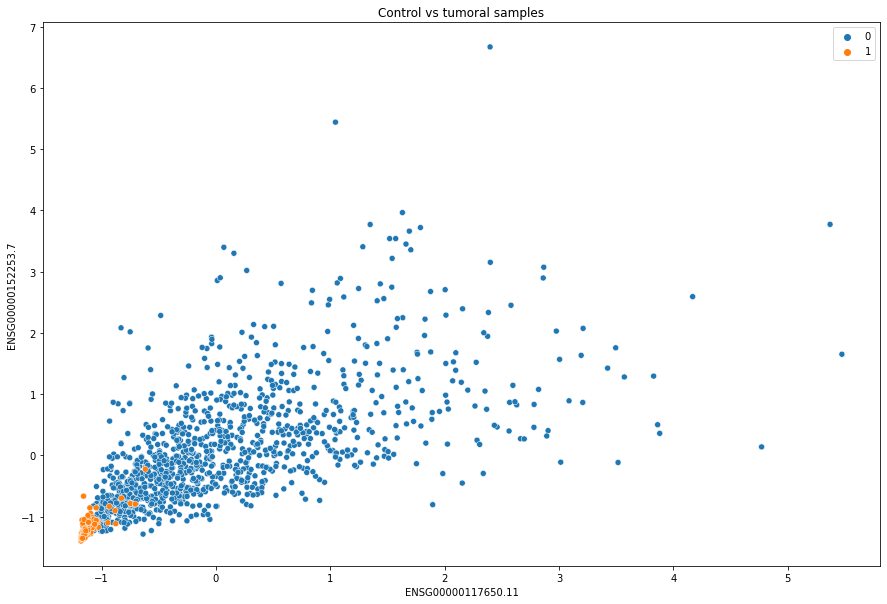

In [379]:
#This is the same procedure used before such that we can have X composed by only 2 features
p_val_matrix_t = p_val_matrix.transpose()
quantile = 2/len(p_val_matrix_t)                          #In this case we use only 2 genes so that we can plot them
threshold = p_val_matrix_t.pval.quantile(quantile)        #Using quantile it extracts the number of feature we want
diff_expressed = p_val_matrix_t[p_val_matrix_t.pval < threshold]
diff_expressed = diff_expressed.transpose()
X = diff_expressed.iloc[:-1,:]
Y_b = Y.transpose()
y = Y_b.to_numpy().astype(np.int64)
y = y.reshape(len(X))

#Plot of tumoral vs control samples when X has only 2 features
figure = plt.figure(figsize = (15,10))
fig = sns.scatterplot(X.iloc[:,0], X.iloc[:,1], hue = y)
fig.set_title("Control vs tumoral samples")

## Algorithms used

To obtain a good result the best strategy is to test different algorithms. In this case 4 of them were considered which are Logistic Regression, K Nearest Neighbors, Random Forest and Support Vector Machines. All of them perform very well and it is difficult to assess which is the best among the 4 due to the low number of samples especially for the controls. What we can say is that, as mentioned before, our objective should be interpretability which means that complex algorithms like Support Vector Machines and Random Forest should not be preferred to simplest one like Logistic Regression and KNN, unless there is an evident difference in terms of performances.

The first thing that we can try to do is to understand which is the best number of features for the algorithms. Different algortihms may perform better with a different number of features. We can divide the whole data set in train set and test set and when it was possible the train set was further divided in train and validation set. 
From the plot we can clearly see a common trend for all the algorithms, all of them tend to perform better when more than 50 features are used. Looking at the validation set seems that the accuracy for each model contiue to improve with the number of features, however this trend is not visible in the plot of test score. This is probably due to overfitting, if we select a big number of features our train score will be very high because the model is learning everything about the train set, but when we use this model on the test the results will not be good anymore due to the variability of the data. This kind of behaviour is known as bias-variance trade-off. <br/>
Since the results are pretty similar for each model we decide to use the same number of features for each model, in particulare we will use 80 features so that we can avoid to overfit.

Text(0, 0.5, 'Accuracy')

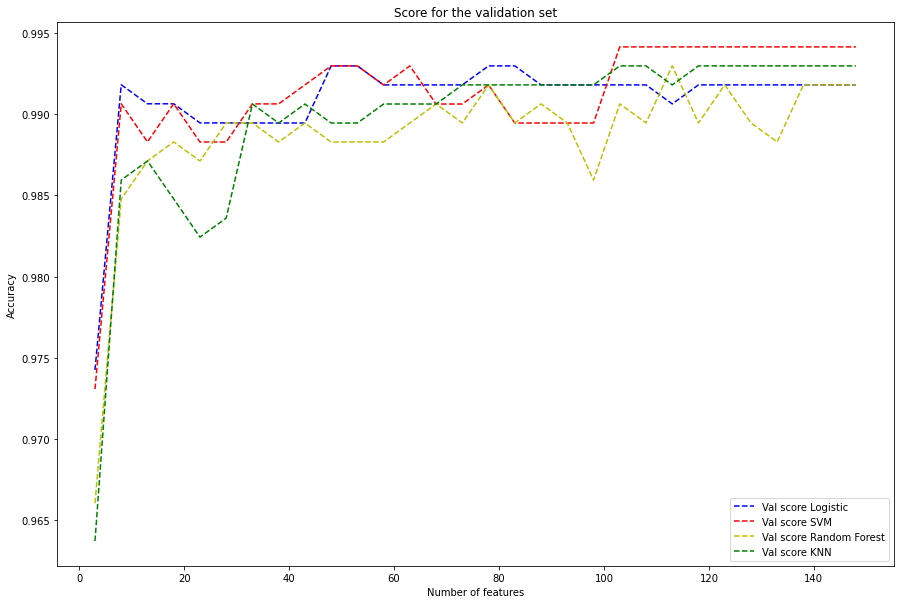

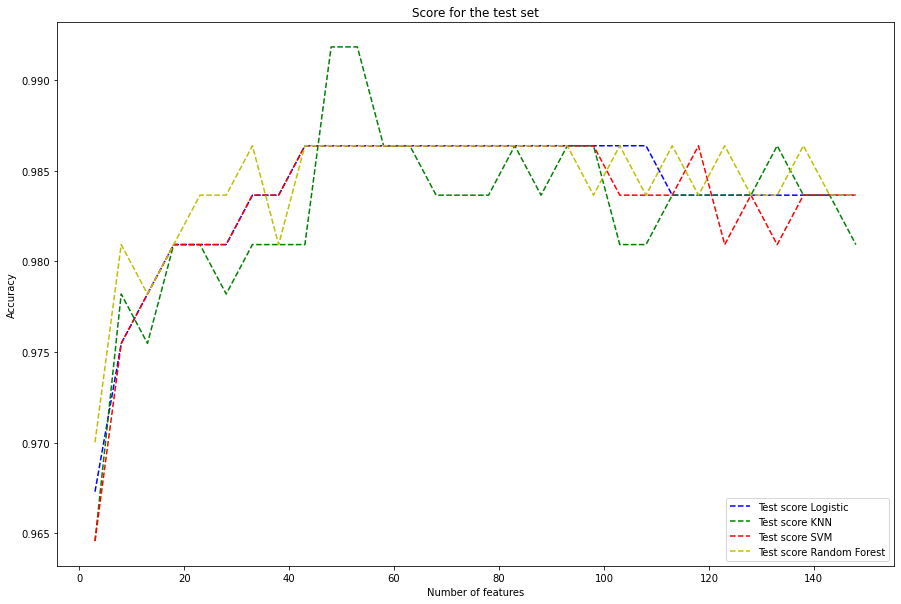

In [400]:
log_test_score = []
SVC_test_score = []
Rand_For_test_score = []
KNN_test_score = []

log_val_score = []
SVC_val_score = []    
Rand_For_val_score = []
KNN_val_score = []
    
starting_number_of_features = 3         #Minimum number of feature considered                  
maximum_number_of_features = 150        #Maximum number of feature considered
interval = 5                            #We will train models incrementing the number of features every time by 5
#Essentially in this case we will train models with 3,8,13...148 features

for number_of_features in range(starting_number_of_features, maximum_number_of_features, interval):
    #This block that is present almost in every cell is used to compute X and y every time with the new number of features
    p_val_matrix_t = p_val_matrix.transpose()
    quantile = number_of_features/len(p_val_matrix_t)
    threshold = p_val_matrix_t.pval.quantile(quantile)
    diff_expressed = p_val_matrix_t[p_val_matrix_t.pval < threshold]
    diff_expressed = diff_expressed.transpose()
    X = diff_expressed.iloc[:-1,:]
    Y_b = Y.transpose()
    y = Y_b.to_numpy().astype(np.int64)
    
    #Percentage of data used for the test
    split_test_size = 0.3
    
    #Seed used for the division of all data
    seed = 40
        
    #Dividing the dataset in train and test set    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size, 
                                                    random_state=seed)
    
    #Using kfold we will get different train and validation set that can be used to train the models
    #In this case we will k = 5
    num_folds = 5
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    
    #The cross val score function divide the X_train and y_train more computing the accuracy for the validation fold
    #Basically we will get 10 accuracy score from cross val, we average them using np.mean and we append the result in log_val_score
    log_val_score.append(np.mean(cross_val_score(LogisticRegression(solver="newton-cg", penalty='l2'), X_train, y_train, cv = kfold)))
    SVC_val_score.append(np.mean(cross_val_score(SVC(), X_train, y_train, cv = kfold)))
    Rand_For_val_score.append(np.mean(cross_val_score(RandomForestClassifier(), X_train, y_train, cv = kfold)))
    KNN_val_score.append(np.mean(cross_val_score(KNeighborsClassifier(), X_train, y_train, cv = kfold)))
    
    #After have done cross validation on the train set for all the 4 algorithms we compute the test accuracy
    #This is the test score for logistic regression
    log = LogisticRegression(solver="newton-cg", penalty='l2')
    log.fit(X_train, y_train)
    log_test_score.append(log.score(X_test, y_test))
    
    #support vector machines
    sv = SVC()
    sv.fit(X_train, y_train)
    SVC_test_score.append(sv.score(X_test, y_test))
    
    #Random forest    
    rand_for = RandomForestClassifier()
    rand_for.fit(X_train, y_train)
    Rand_For_test_score.append(rand_for.score(X_test, y_test))
    
    #KNN    
    KNN = KNeighborsClassifier()
    KNN.fit(X_train, y_train)
    KNN_test_score.append(KNN.score(X_test, y_test))

#In this section I plot two graphs, the first where we have the results of the validation set based on the number of features 
#used, the second where we have the results of the test. As I said before those results can give only an idea of the ideal
#number of features. To have more reliable results more data are needed, it is easy to verify that just changing the seed,
#which affect the division in test, train and calidation, the results change. The only thing that we can say for sure is that
#for every algorithm we seem to have a better performance with 50+ features, after that we reach a plateu.

#Plot of validation score and test score
plt.figure(figsize = (15,10))
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), log_val_score, "b--", label="Val score Logistic")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), SVC_val_score, "r--", label="Val score SVM")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), Rand_For_val_score, "y--", label="Val score Random Forest")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), KNN_val_score, "g--", label="Val score KNN")
plt.legend(loc="lower right")
plt.title("Score for the validation set")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")


plt.figure(figsize = (15,10))
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), log_test_score, "b--", label="Test score Logistic")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), KNN_test_score, "g--", label="Test score KNN")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), SVC_test_score, "r--", label="Test score SVM")
plt.plot(range(starting_number_of_features, maximum_number_of_features, interval), Rand_For_test_score, "y--", label="Test score Random Forest")
plt.legend(loc="lower right")
plt.title("Score for the test set")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")

# Logistic regression

Now that we have a general idea on the performance of our models we can try to modify the hyperparameters of them. Until now we have basically use the default parameters for every algorithm, however there are many of them that can be modified. <br/>
We start with the logistic regression where the first parameter that we can modify is the threshold for which we decide to assign a sample as control or tumoral. In the default option of sklearn the logistic regression use a threshold of 0.5. Unfortunately we can't modify it through sklearn but we have to implement this function manually. In the next we will create a list in which we store some possible thresholds. Then we will compute the accuracy, the recall and the precision using every of them.

So we will train a model which use as X the matrix containing the 80 features mentioned above, then we compute the predicted probabilities for the test set and at every iteration of the loop we assigne the samples to a class depending on the threshold. For every threshold we can see the confusion matrix, from which we can read true positive, true negative, false positive and false negative. Then with those we can compute precision, recall and accuracy, moreover with the function classification_report() we can also get other values like the F1 score. <br/>
Finally we can plot the graph of those quantities and decide which is the best according to our problem, we may decide to maximize one, for example the recall but, we will pay this choice in terms of precision. The basic idea is that we have a trade-off between recall and precision and we decide according to our objective.

In [389]:
feat = 80   #This is the number of features that we are going to use from now 

#To compute the X matrix we always use the same method
p_val_matrix_t = p_val_matrix.transpose()
quantile = feat/len(p_val_matrix_t)
threshold = p_val_matrix_t.pval.quantile(quantile)
diff_expressed = p_val_matrix_t[p_val_matrix_t.pval < threshold]
diff_expressed = diff_expressed.transpose()
X = diff_expressed.iloc[:-1,:]
Y_b = Y.transpose()
y = Y_b.to_numpy().astype(np.int64)
y = y.reshape(len(X))
X                                                 #We visualize X 

gene_id,ENSG00000143418.18,ENSG00000143543.13,ENSG00000143612.17,ENSG00000160688.17,ENSG00000169241.16,ENSG00000116521.9,ENSG00000160753.14,ENSG00000132676.14,ENSG00000183856.9,ENSG00000143321.17,...,ENSG00000237649.6,ENSG00000198937.8,ENSG00000137216.17,ENSG00000122641.9,ENSG00000168078.8,ENSG00000164932.11,ENSG00000123975.4,ENSG00000102100.13,ENSG00000090889.11,ENSG00000186871.6
fpkm0,0.579360,-0.208894,0.034494,0.213366,-0.261034,0.072259,0.341835,0.360602,-0.084868,-0.414435,...,-0.577022,-0.554060,0.411701,-0.529853,-0.800920,-0.414435,-0.473912,-0.184800,-0.503992,-0.724438
fpkm1,1.761317,1.074721,1.193690,-0.097273,0.595749,0.324224,0.007769,1.630499,-0.849126,0.012859,...,-0.874423,-0.236276,-0.350563,-0.150756,-0.713053,0.848612,-0.543186,-0.438896,-0.954269,-0.695827
fpkm2,1.253634,-0.255961,0.103877,0.719482,0.957690,0.208091,-0.191500,0.568192,-0.008217,0.472593,...,0.211219,0.429231,1.897384,0.347258,-0.508512,-0.164873,0.471630,-0.019942,0.183205,-0.530831
fpkm3,3.590531,-0.123248,2.245590,-0.219016,-0.099669,0.525834,0.180077,1.082548,0.536434,-0.258599,...,-0.516720,-0.424828,0.770871,-0.290332,0.959585,-0.287595,-0.490086,-0.074434,-0.233166,0.326744
fpkm4,-1.335696,0.905191,-1.094790,-0.616112,-0.534532,-0.108366,-0.529381,-0.991515,-0.802612,-0.383128,...,-0.335318,0.942479,-0.849061,-0.872483,-0.567875,-0.330987,-0.375402,-0.757179,-0.867961,-0.791544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm1216,-1.120449,-1.329872,-0.630600,-1.073125,-1.277763,-1.306865,-1.407491,-1.178650,-1.017480,-1.583285,...,-1.083160,-1.251900,-1.433245,-0.962456,-1.005169,-1.221147,-1.143176,-1.516229,-1.136443,-1.094254
fpkm1217,-1.067863,-1.184582,-1.272244,-0.942974,-1.095407,-1.158709,-1.047428,-1.173767,-0.972078,-1.012339,...,-1.013489,-0.943944,-1.070430,-0.936147,-0.957878,-1.151272,-0.933517,-1.051073,-1.109390,-1.105618
fpkm1218,-1.186640,-1.327403,-1.057346,-0.956861,-1.284220,-1.270279,-1.405160,-1.322846,-1.005238,-1.291967,...,-1.062651,-1.139874,-1.321732,-1.007974,-0.999417,-1.100043,-1.119691,-1.457695,-1.122480,-1.156541
fpkm1219,-1.105438,-1.219108,-1.347053,-1.114017,-1.127033,-1.273227,-1.155926,-1.135590,-0.995580,-1.014970,...,-0.984417,-1.096881,-1.108260,-1.007807,-0.975043,-1.229454,-0.952449,-1.010383,-1.091633,-0.943341



******** For i = 0.05 ******
[[332   4]
 [  1  30]]
              precision    recall  f1-score   support

           0  0.99699700 0.98809524 0.99252616       336
           1  0.88235294 0.96774194 0.92307692        31

    accuracy                      0.98637602       367
   macro avg  0.93967497 0.97791859 0.95780154       367
weighted avg  0.98731317 0.98637602 0.98665987       367


******** For i = 0.1 ******
[[332   4]
 [  1  30]]
              precision    recall  f1-score   support

           0  0.99699700 0.98809524 0.99252616       336
           1  0.88235294 0.96774194 0.92307692        31

    accuracy                      0.98637602       367
   macro avg  0.93967497 0.97791859 0.95780154       367
weighted avg  0.98731317 0.98637602 0.98665987       367


******** For i = 0.15 ******
[[332   4]
 [  1  30]]
              precision    recall  f1-score   support

           0  0.99699700 0.98809524 0.99252616       336
           1  0.88235294 0.96774194 0.92307692    

(0.0, 1.0)

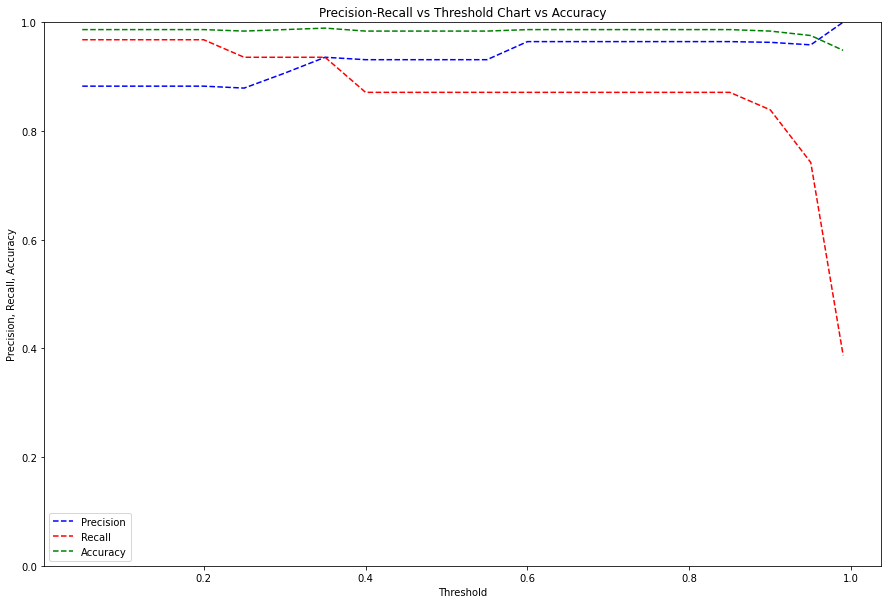

In [412]:
#List of thresholds I'm going to use
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

#We divide the dataset in train and test considering the same seed and test size as before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)

#We fit a model and train it
model = LogisticRegression(solver="newton-cg", penalty='l2')  
model.fit(X_train, y_train)
recall = []
precision = []
acc = []

#Loop over all the thresholds of the list
for i in threshold_list:
    pred_proba_model = pd.DataFrame(model.predict_proba(X_test))           #Prediction of the model
    Y_test_pred = pred_proba_model.applymap(lambda x: 1 if x > i else 0)   #Assign a sample to a class depending on the threshold
    print ('\n******** For i = {} ******'.format(i))
    print(confusion_matrix(y_test, Y_test_pred.iloc[:,1]))          #Confusion matrix
    print(classification_report(y_test, Y_test_pred.iloc[:,1], digits = 8)) #Classification report
    recall.append(recall_score(y_test, Y_test_pred.iloc[:,1]))             #Recall score 
    precision.append(precision_score(y_test, Y_test_pred.iloc[:,1]))       #Precision score
    acc.append(accuracy_score(y_test, Y_test_pred.iloc[:,1]))              #Accuracy score
    
#Plot for recall, precsion and accuracy depending on the threshold
plt.figure(figsize = (15,10))
plt.title("Precision-Recall vs Threshold Chart vs Accuracy")
plt.plot(threshold_list, precision, "b--", label="Precision")
plt.plot(threshold_list, recall, "r--", label="Recall")
plt.plot(threshold_list, acc, "g--", label="Accuracy")
plt.ylabel("Precision, Recall, Accuracy")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### GridSearchCV
The next thing that we can do is look for the hyperparameters of the Logistic regression. To do that we can use the GridSearchCV function, with this we can train different models with different parameters and then compute the test score for them. In particular we divide in test and train and then pass to GridSearch the train set, which divides it in train and validation. <br/>
Once GridSearch return the best parameters for the Logistic Regrssion, we compute the test score on the model with those parameters.

In [391]:
#Compute train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)
#Compute the folds for cross validation
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)

#GridSearch use a dictionary in which we can put our hyperparamters. Here we consider the solver and the strnght of the regularization
Log_hyparams = GridSearchCV(LogisticRegression(penalty = 'l2'), {
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C':[1,10,100,1000]
}, cv = kfold, return_train_score = False)

#Then we train the model 
Log_hyparams.fit(X_train, y_train)
#And we print as a result a dataframe containing all the combination of the parameters with their validation score
print(pd.DataFrame(Log_hyparams.cv_results_, columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']))

#then we select the best parameters and we train a new model with those
best_param = Log_hyparams.best_params_
best_C = best_param['C']
best_solver = best_param['solver']
best_mod = LogisticRegression(solver = best_solver, C = best_C, penalty = 'l2')
best_mod.fit(X_train, y_train)

#On the model that we have train now we compute the test score
print(f'The best parameters are: {best_param}')
print(f'The test score with those parameters is: {best_mod.score(X_test, y_test)}')

                                params  mean_test_score  std_test_score  \
0      {'C': 1, 'solver': 'newton-cg'}         0.992969        0.005741   
1          {'C': 1, 'solver': 'lbfgs'}         0.992969        0.005741   
2      {'C': 1, 'solver': 'liblinear'}         0.991799        0.004689   
3            {'C': 1, 'solver': 'sag'}         0.992969        0.004391   
4           {'C': 1, 'solver': 'saga'}         0.990623        0.005992   
5     {'C': 10, 'solver': 'newton-cg'}         0.991799        0.004689   
6         {'C': 10, 'solver': 'lbfgs'}         0.991799        0.004689   
7     {'C': 10, 'solver': 'liblinear'}         0.988290        0.006406   
8           {'C': 10, 'solver': 'sag'}         0.991799        0.004689   
9          {'C': 10, 'solver': 'saga'}         0.991799        0.004689   
10   {'C': 100, 'solver': 'newton-cg'}         0.990630        0.002876   
11       {'C': 100, 'solver': 'lbfgs'}         0.990630        0.002876   
12   {'C': 100, 'solver':

# SVM, Random Forest and KNN

We can apply what we have done with logistic regression to the other algorithms. In those case we can act on different hyperparameters to find the best combination of them. All the parameters that we tune can be modified through sklearn so we can simply use GridSearchCV.

## KNN

In [398]:
#As before we divide the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)
#And we get the different folds
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)

#In KNN the parameter that we can tune is the number of nearest neighbors
KNN_hyparams = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors':[5,7,10,12,15,20,25,30,50]
}, cv = kfold, return_train_score = False)

#We train the model
KNN_hyparams.fit(X_train, y_train)
#We compute the validation score for every paramter combination
print(pd.DataFrame(KNN_hyparams.cv_results_, columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']))

#We select the best paramter according to GridSearchCV
best_param = KNN_hyparams.best_params_
best_neighbors = best_param['n_neighbors']
best_mod = KNeighborsClassifier(n_neighbors = best_neighbors)
best_mod.fit(X_train, y_train)

#And finally we compute the test score for the new model 
print(f'The best parameters are: {best_param}')
print(f'The test score with those parameters is: {best_mod.score(X_test, y_test)}')

                params  mean_test_score  std_test_score  rank_test_score
0   {'n_neighbors': 5}         0.991799        0.004689                1
1   {'n_neighbors': 7}         0.989453        0.005755                6
2  {'n_neighbors': 10}         0.990623        0.005992                3
3  {'n_neighbors': 12}         0.991799        0.004689                1
4  {'n_neighbors': 15}         0.989460        0.006822                4
5  {'n_neighbors': 20}         0.989460        0.006822                4
6  {'n_neighbors': 25}         0.987114        0.005747                7
7  {'n_neighbors': 30}         0.987114        0.005747                7
8  {'n_neighbors': 50}         0.984775        0.005972                9
The best parameters are: {'n_neighbors': 5}
The test score with those parameters is: 0.9836512261580381


## SVM

In principle it may be possible also to modify the threshold like in Logistic Regression. In this case we would not modify the threshold but the margin that divides the two classes, instead of having the maximum margin we may have an asymmetric margin such that we can act on recall and precision. However this aspect is not implemented in the code.

In [393]:
#As before we divide the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)
#And we get the different folds
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)

#In SVM the parameter to tune is the kernel we are going to use. 
SVC_hyparams = GridSearchCV(SVC(), {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid']
}, cv = kfold, return_train_score = False)

#We train the model
SVC_hyparams.fit(X_train, y_train)
#We compute the validation score for every paramter combination
print(pd.DataFrame(SVC_hyparams.cv_results_, columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']))

#We select the best paramter according to GridSearchCV
best_param = SVC_hyparams.best_params_
best_kernel = best_param['kernel']
best_mod = SVC(kernel = best_kernel)
best_mod.fit(X_train, y_train)

#And finally we compute the test score for the new model
print(f'The best parameters are: {best_param}')
print(f'The test score with those parameters is: {best_mod.score(X_test, y_test)}')

                  params  mean_test_score  std_test_score  rank_test_score
0   {'kernel': 'linear'}         0.990630        0.004685                3
1     {'kernel': 'poly'}         0.991799        0.004689                1
2      {'kernel': 'rbf'}         0.991792        0.007045                2
3  {'kernel': 'sigmoid'}         0.974241        0.013635                4
The best parameters are: {'kernel': 'poly'}
The test score with those parameters is: 0.9863760217983651


## Random forest

In [395]:
#As before we divide the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)
#And we get the different folds
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle = True)

#In random forest the parameter that we are going to tune is the number of estimators
Rand_For_hyparams = GridSearchCV(RandomForestClassifier(), {
    'n_estimators':[1,10,20,30,50,75,100,150,200,300,500]
}, cv = kfold, return_train_score = False)

#We train the model
Rand_For_hyparams.fit(X_train, y_train)
#We compute the validation score for every paramter combination
print(pd.DataFrame(Rand_For_hyparams.cv_results_, columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']))

#We select the best paramter according to GridSearchCV
best_param = Rand_For_hyparams.best_params_
best_n_estimators = best_param['n_estimators']
best_mod = RandomForestClassifier(n_estimators = best_n_estimators)
best_mod.fit(X_train, y_train)

#And finally we compute the test score for the new model
print(f'The best parameters are: {best_param}')
print(f'The test score with those parameters is: {best_mod.score(X_test, y_test)}')

                   params  mean_test_score  std_test_score  rank_test_score
0     {'n_estimators': 1}         0.975418        0.011327               11
1    {'n_estimators': 10}         0.987107        0.006862               10
2    {'n_estimators': 20}         0.989453        0.004409                6
3    {'n_estimators': 30}         0.990623        0.004715                3
4    {'n_estimators': 50}         0.989460        0.004380                5
5    {'n_estimators': 75}         0.989460        0.002346                4
6   {'n_estimators': 100}         0.987114        0.004398                9
7   {'n_estimators': 150}         0.989453        0.004409                6
8   {'n_estimators': 200}         0.990630        0.002876                1
9   {'n_estimators': 300}         0.988283        0.005254                8
10  {'n_estimators': 500}         0.990630        0.002876                1
The best parameters are: {'n_estimators': 200}
The test score with those parameters is: 

### Alternative

We may also do all of this using a single dictionary, this is easier if we want to compare the different models that we have used.

In [359]:
#In this dictionary we have all the possible parameters that we can use to fit our models. 
model_params = {
    'svm': {
        'model': SVC(),
        'params':{
            'kernel':['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1,10,20,30,50,100,200,300]
        }
    },
    'logistic_regression':{
        'model': LogisticRegression(),
        'params':{
            'solver': ['liblinear','newton-cg', 'sag', 'saga', 'lbfgs'],
        }
    },
    'nearest_neighbor': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1,5,7,10,12,15,20,25,30]
        }
    }
}

In [399]:
scores = []

#We divide our dataset in train and test sed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = seed)

#We loop over every model that we have in the dictionary 
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = kfold, return_train_score = False)   #Select the model and the parameters
    clf.fit(X_train, y_train)     #Fit the model
    scores.append({               #Save the score in a dataframe
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
pd.DataFrame(scores)           #Those are the models with the best parameters, those are not test scores, so they are higher

,model,best_score,best_params
0,svm,0.991799,{'kernel': 'poly'}
1,random_forest,0.990630,{'n_estimators': 100}
2,logistic_regression,0.992969,{'solver': 'newton-cg'}
3,nearest_neighbor,0.991799,{'n_neighbors': 5}


# Conclusion

What we get are those models that can offer an accuracy which is almost the 99%, but as mentioned before it is really difficult to compare different models due to the fact that they are very similar and accurate and we don't have many data. Since we have seen that more complex methods like SVM and Random Forest are not much better than the others we should avoid this in order to have a better interpretability of the results. <br/>
To get better results it may be usefull to have more samples and it will also be possible use different techniques. The first thing that it could be possible is to use a diferent method for feature selection as mentioned before, doing this we may be able to find the more relevant variables. Another improvement could be obtained using different algorithms, for example Linear and Quadratic Discriminant Analysis. However, I would consider those results pretty good since we should be able to classify correctly the majority of the results.